# Energy Usage Prediction - Hyeondeok Cho

In [1]:
import pandas as pd
import numpy as np
import datetime
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error

In [2]:
#Task 1
#Examine the data, parse the time fields wherever necessary. Take the sum of the energy usage
#(Use [kW]) to get per day usage and merge it with weather data

#Dataframe for weather and energy
weather_data = pd.read_csv('weather_data.csv')
energy_data = pd.read_csv('energy_data.csv')

In [3]:
weather_data.head()

,temperature,icon,humidity,visibility,summary,pressure,windSpeed,cloudCover,time,windBearing,precipIntensity,dewPoint,precipProbability
0,34.98,partly-cloudy-night,0.64,10.00,Partly Cloudy,1017.69,7.75,0.29,1388534400,279,0.0,23.89,0.0
1,16.49,clear-night,0.62,10.00,Clear,1022.76,2.71,0.06,1388538000,195,0.0,5.87,0.0
2,14.63,clear-night,0.68,10.00,Clear,1022.32,4.84,0.03,1388541600,222,0.0,6.17,0.0
3,13.31,clear-night,0.71,10.00,Clear,1021.64,4.00,0.14,1388545200,209,0.0,5.63,0.0
4,13.57,clear-night,0.71,9.93,Clear,1020.73,3.67,0.04,1388548800,217,0.0,5.87,0.0


In [4]:
#In the "time" column from weather data, each row should be unique.
#check if there is duplicated value of time.
weather_data[weather_data.duplicated(subset=['time'])]

,temperature,icon,humidity,visibility,summary,pressure,windSpeed,cloudCover,time,windBearing,precipIntensity,dewPoint,precipProbability


There is no duplicated time in weather_data.

In [5]:
#check if there is any null value in weather_data
weather_data.isnull().any()

temperature          False
icon                 False
humidity             False
visibility           False
summary              False
pressure             False
windSpeed            False
cloudCover            True
time                 False
windBearing          False
precipIntensity      False
dewPoint             False
precipProbability    False
dtype: bool

In [6]:
weather_data['cloudCover'].isnull().sum()

1470

There are 1470 rows that have null values in the "cloudCover" column from weather_data, but I don't think they will affect significantly to my prediction of the electricity usage based on weather condition, so I would just leave them as null values.

In [7]:
energy_data.head()

,Date & Time,use [kW],gen [kW],Grid [kW],AC [kW],Furnace [kW],Cellar Lights [kW],Washer [kW],First Floor lights [kW],Utility Rm + Basement Bath [kW],Garage outlets [kW],MBed + KBed outlets [kW],Dryer + egauge [kW],Panel GFI (central vac) [kW],Home Office (R) [kW],Dining room (R) [kW],Microwave (R) [kW],Fridge (R) [kW]
0,2014-01-01 00:00:00,0.304439,0.0,0.304439,0.000058,0.009531,0.005336,0.000126,0.011175,0.003836,0.004836,0.002132,0.000009,0.007159,0.063666,0.004299,0.004733,0.042589
1,2014-01-01 00:30:00,0.656771,0.0,0.656771,0.001534,0.364338,0.005522,0.000043,0.003514,0.003512,0.004888,0.002137,0.000107,0.007221,0.064698,0.003589,0.004445,0.096008
2,2014-01-01 01:00:00,0.612895,0.0,0.612895,0.001847,0.417989,0.005504,0.000044,0.003528,0.003484,0.004929,0.002052,0.000170,0.007197,0.065109,0.003522,0.004396,0.025928
3,2014-01-01 01:30:00,0.683979,0.0,0.683979,0.001744,0.410653,0.005556,0.000059,0.003499,0.003476,0.004911,0.002068,0.000121,0.007236,0.065032,0.003404,0.004262,0.105472
4,2014-01-01 02:00:00,0.197809,0.0,0.197809,0.000030,0.017152,0.005302,0.000119,0.003694,0.003865,0.004876,0.002087,0.000052,0.007133,0.062451,0.003915,0.004407,0.016798


In [8]:
#In the "Date & Time" column from energy_data, each row should be unique.
#check if there is duplicated value of "Date & Time"
energy_data[energy_data.duplicated(subset=['Date & Time'])]

,Date & Time,use [kW],gen [kW],Grid [kW],AC [kW],Furnace [kW],Cellar Lights [kW],Washer [kW],First Floor lights [kW],Utility Rm + Basement Bath [kW],Garage outlets [kW],MBed + KBed outlets [kW],Dryer + egauge [kW],Panel GFI (central vac) [kW],Home Office (R) [kW],Dining room (R) [kW],Microwave (R) [kW],Fridge (R) [kW]
14641,2014-11-02 01:00:00,0.483964,0.0,0.483964,0.000019,0.009070,0.010133,0.000276,0.003584,0.002243,0.004720,0.048174,0.000090,0.000261,0.0,0.0,0.0,0.0
14643,2014-11-02 01:30:00,0.474490,0.0,0.474490,0.000034,0.009326,0.018928,0.000294,0.003708,0.002368,0.004942,0.049934,0.000084,0.000261,0.0,0.0,0.0,0.0


After checking duplicated value, it shows that there are two duplicated rows, but even though they are same date, time is different. So we can safely assume that both of them are unique in terms of Date & Time.

In [9]:
#check if there is any null value in energy_data
energy_data.isnull().any()

Date & Time                        False
use [kW]                           False
gen [kW]                           False
Grid [kW]                          False
AC [kW]                            False
Furnace [kW]                       False
Cellar Lights [kW]                 False
Washer [kW]                        False
First Floor lights [kW]            False
Utility Rm + Basement Bath [kW]    False
Garage outlets [kW]                False
MBed + KBed outlets [kW]           False
Dryer + egauge [kW]                False
Panel GFI (central vac) [kW]       False
Home Office (R) [kW]               False
Dining room (R) [kW]               False
Microwave (R) [kW]                 False
Fridge (R) [kW]                    False
dtype: bool

There is no null values in energy_data

In [10]:
#Since the "Date & Time" column is object type, we can convert it to datetime type
energy_data['Date & Time'] = pd.to_datetime(energy_data['Date & Time'])

In [11]:
energy_data.head()

,Date & Time,use [kW],gen [kW],Grid [kW],AC [kW],Furnace [kW],Cellar Lights [kW],Washer [kW],First Floor lights [kW],Utility Rm + Basement Bath [kW],Garage outlets [kW],MBed + KBed outlets [kW],Dryer + egauge [kW],Panel GFI (central vac) [kW],Home Office (R) [kW],Dining room (R) [kW],Microwave (R) [kW],Fridge (R) [kW]
0,2014-01-01 00:00:00,0.304439,0.0,0.304439,0.000058,0.009531,0.005336,0.000126,0.011175,0.003836,0.004836,0.002132,0.000009,0.007159,0.063666,0.004299,0.004733,0.042589
1,2014-01-01 00:30:00,0.656771,0.0,0.656771,0.001534,0.364338,0.005522,0.000043,0.003514,0.003512,0.004888,0.002137,0.000107,0.007221,0.064698,0.003589,0.004445,0.096008
2,2014-01-01 01:00:00,0.612895,0.0,0.612895,0.001847,0.417989,0.005504,0.000044,0.003528,0.003484,0.004929,0.002052,0.000170,0.007197,0.065109,0.003522,0.004396,0.025928
3,2014-01-01 01:30:00,0.683979,0.0,0.683979,0.001744,0.410653,0.005556,0.000059,0.003499,0.003476,0.004911,0.002068,0.000121,0.007236,0.065032,0.003404,0.004262,0.105472
4,2014-01-01 02:00:00,0.197809,0.0,0.197809,0.000030,0.017152,0.005302,0.000119,0.003694,0.003865,0.004876,0.002087,0.000052,0.007133,0.062451,0.003915,0.004407,0.016798


In [12]:
#create new column called "Date" in order to to take sum the sum of the energy usage(Use [kW]) per day.
energy_data['Date'] = pd.to_datetime(energy_data['Date & Time']).dt.date

In [13]:
energy_data.head()

,Date & Time,use [kW],gen [kW],Grid [kW],AC [kW],Furnace [kW],Cellar Lights [kW],Washer [kW],First Floor lights [kW],Utility Rm + Basement Bath [kW],Garage outlets [kW],MBed + KBed outlets [kW],Dryer + egauge [kW],Panel GFI (central vac) [kW],Home Office (R) [kW],Dining room (R) [kW],Microwave (R) [kW],Fridge (R) [kW],Date
0,2014-01-01 00:00:00,0.304439,0.0,0.304439,0.000058,0.009531,0.005336,0.000126,0.011175,0.003836,0.004836,0.002132,0.000009,0.007159,0.063666,0.004299,0.004733,0.042589,2014-01-01
1,2014-01-01 00:30:00,0.656771,0.0,0.656771,0.001534,0.364338,0.005522,0.000043,0.003514,0.003512,0.004888,0.002137,0.000107,0.007221,0.064698,0.003589,0.004445,0.096008,2014-01-01
2,2014-01-01 01:00:00,0.612895,0.0,0.612895,0.001847,0.417989,0.005504,0.000044,0.003528,0.003484,0.004929,0.002052,0.000170,0.007197,0.065109,0.003522,0.004396,0.025928,2014-01-01
3,2014-01-01 01:30:00,0.683979,0.0,0.683979,0.001744,0.410653,0.005556,0.000059,0.003499,0.003476,0.004911,0.002068,0.000121,0.007236,0.065032,0.003404,0.004262,0.105472,2014-01-01
4,2014-01-01 02:00:00,0.197809,0.0,0.197809,0.000030,0.017152,0.005302,0.000119,0.003694,0.003865,0.004876,0.002087,0.000052,0.007133,0.062451,0.003915,0.004407,0.016798,2014-01-01


In [14]:
#usekw_data is data frame of the sum of the energy usage(Use [kW]) per day (grouped by 'Date')
usekw_data = energy_data.groupby('Date').sum()
usekw_data = usekw_data[['use [kW]']]
usekw_data.head()

,use [kW]
Date,
2014-01-01,65.013592
2014-01-02,32.305336
2014-01-03,31.164468
2014-01-04,45.287782
2014-01-05,36.316643


In [15]:
#In weather_data, the column 'time' is represented as second, so we should convert it to datetime type
#I added new column "Date" and put converted value into it.

weather_data['Date'] = pd.to_datetime(weather_data['time'], unit='s').dt.date

#grouby 'Date' and take average of rows of other columns

new_weather_data = weather_data.groupby('Date').mean()
weather_data = new_weather_data.drop(columns=['time'])

In [16]:
weather_data.head()

,temperature,humidity,visibility,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
Date,,,,,,,,,,
2014-01-01,20.110833,0.556667,9.970000,1025.395000,6.820417,0.031304,252.291667,0.000000,6.362083,0.000000
2014-01-02,16.382500,0.784583,3.834583,1023.465833,7.433750,0.354444,53.458333,0.002004,10.737083,0.074583
2014-01-03,6.256667,0.680833,4.509167,1014.428750,12.828333,0.186364,207.333333,0.002029,-2.337500,0.080000
2014-01-04,2.711667,0.617083,9.822917,1030.096250,5.248333,0.001667,240.166667,0.000000,-8.352083,0.000000
2014-01-05,17.654167,0.682083,9.134583,1025.275000,3.417083,0.010952,208.958333,0.000033,8.615000,0.000417


In [17]:
#merge two dataframe on 'Date'
data = pd.merge(usekw_data,weather_data, on = 'Date', how = "left")

In [18]:
data.head()

,use [kW],temperature,humidity,visibility,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
Date,,,,,,,,,,,
2014-01-01,65.013592,20.110833,0.556667,9.970000,1025.395000,6.820417,0.031304,252.291667,0.000000,6.362083,0.000000
2014-01-02,32.305336,16.382500,0.784583,3.834583,1023.465833,7.433750,0.354444,53.458333,0.002004,10.737083,0.074583
2014-01-03,31.164468,6.256667,0.680833,4.509167,1014.428750,12.828333,0.186364,207.333333,0.002029,-2.337500,0.080000
2014-01-04,45.287782,2.711667,0.617083,9.822917,1030.096250,5.248333,0.001667,240.166667,0.000000,-8.352083,0.000000
2014-01-05,36.316643,17.654167,0.682083,9.134583,1025.275000,3.417083,0.010952,208.958333,0.000033,8.615000,0.000417


In [19]:
#Task 2
#Split the data obtained from step 1, into training and testing sets. The aim is to predict the usage
#for each day in the month of December using the weather data, so split accordingly. The usage as
#per devices should be dropped, only the “use [kW]” column is to be used for prediction from the dataset

#we are going to consider training set as data from January to November, and testing set as data of December

#training_set
training_set = data[data.index < datetime.date(2014,12,1)]
training_set

,use [kW],temperature,humidity,visibility,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
Date,,,,,,,,,,,
2014-01-01,65.013592,20.110833,0.556667,9.970000,1025.395000,6.820417,0.031304,252.291667,0.000000,6.362083,0.000000
2014-01-02,32.305336,16.382500,0.784583,3.834583,1023.465833,7.433750,0.354444,53.458333,0.002004,10.737083,0.074583
2014-01-03,31.164468,6.256667,0.680833,4.509167,1014.428750,12.828333,0.186364,207.333333,0.002029,-2.337500,0.080000
2014-01-04,45.287782,2.711667,0.617083,9.822917,1030.096250,5.248333,0.001667,240.166667,0.000000,-8.352083,0.000000
2014-01-05,36.316643,17.654167,0.682083,9.134583,1025.275000,3.417083,0.010952,208.958333,0.000033,8.615000,0.000417
...,...,...,...,...,...,...,...,...,...,...,...
2014-11-26,27.712850,36.385000,0.778333,6.551667,1019.266250,6.445833,0.171333,185.375000,0.024837,29.875417,0.291250
2014-11-27,30.114004,31.992500,0.847083,7.394583,1012.272917,7.599167,0.420769,316.833333,0.006033,27.862083,0.160417
2014-11-28,26.348404,29.126250,0.763750,8.919167,1018.359583,6.599167,0.268947,316.416667,0.000271,22.335000,0.006667


In [20]:
#testing set
testing_set = data[data.index>= datetime.date(2014,12,1)]
testing_set

,use [kW],temperature,humidity,visibility,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
Date,,,,,,,,,,,
2014-12-01,30.550010,45.276250,0.722083,9.656667,1018.805417,6.397083,0.263333,226.958333,0.000000,36.748750,0.000000
2014-12-02,31.748857,34.177917,0.582917,9.839583,1034.805833,7.527083,0.121818,166.625000,0.000000,21.006250,0.000000
2014-12-03,28.773233,36.345833,0.911250,4.939167,1022.247500,5.691250,0.862000,119.333333,0.010754,33.994167,0.240833
2014-12-04,39.484491,36.216250,0.584167,9.976667,1024.064583,9.129583,0.130000,286.125000,0.000371,22.777500,0.010000
2014-12-05,33.342503,27.463750,0.698750,9.847083,1035.654167,3.421667,0.069130,63.833333,0.000000,18.462083,0.000000
2014-12-06,36.470153,34.868750,0.909167,4.692500,1026.207500,3.397083,0.862000,117.791667,0.022008,32.409167,0.476667
2014-12-07,26.486585,33.502917,0.641667,9.490417,1029.725000,12.755417,0.170952,50.000000,0.009396,21.621250,0.168333
2014-12-08,23.013980,19.519583,0.562917,9.980833,1039.599583,8.700000,0.062105,15.458333,0.000000,6.322917,0.000000
2014-12-09,27.954351,30.960417,0.857500,6.005417,1023.523333,10.067500,1.000000,20.000000,0.037779,27.157500,0.342083


In [21]:
#Task 3
#Linear Regression - Predicting Energy Usage:
#Set up a simple linear regression model to train, and then predict energy usage for each day in the
#month of December using features from weather data (Note that you need to drop the “use [kW]”
#column in the test set first). How well/badly does the model work? (Evaluate the correctness of
#your predictions based on the original “use [kW]” column). Calculate the Root mean squared error
#of your model.
#Finally generate a csv dump of the predicted values. Format of csv: Two columns, first should be
#the date and second should be the predicted value

#first of all, drop the "use [kW] in the test set"
testingset_usekw = testing_set[['use [kW]']]

testing_set = testing_set.drop(columns=['use [kW]'])
testing_set.head()

,temperature,humidity,visibility,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
Date,,,,,,,,,,
2014-12-01,45.276250,0.722083,9.656667,1018.805417,6.397083,0.263333,226.958333,0.000000,36.748750,0.000000
2014-12-02,34.177917,0.582917,9.839583,1034.805833,7.527083,0.121818,166.625000,0.000000,21.006250,0.000000
2014-12-03,36.345833,0.911250,4.939167,1022.247500,5.691250,0.862000,119.333333,0.010754,33.994167,0.240833
2014-12-04,36.216250,0.584167,9.976667,1024.064583,9.129583,0.130000,286.125000,0.000371,22.777500,0.010000
2014-12-05,27.463750,0.698750,9.847083,1035.654167,3.421667,0.069130,63.833333,0.000000,18.462083,0.000000


In [22]:
#testingset_usekw is the testing set that only contains the "use [kW]" column
testingset_usekw.head()

,use [kW]
Date,
2014-12-01,30.550010
2014-12-02,31.748857
2014-12-03,28.773233
2014-12-04,39.484491
2014-12-05,33.342503


In [23]:
#In order to create Linear regression model, we also have to split up the training_set
trainingset_usekw = training_set[['use [kW]']]
training_set =  training_set.drop(columns=['use [kW]'])
training_set.head()

,temperature,humidity,visibility,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
Date,,,,,,,,,,
2014-01-01,20.110833,0.556667,9.970000,1025.395000,6.820417,0.031304,252.291667,0.000000,6.362083,0.000000
2014-01-02,16.382500,0.784583,3.834583,1023.465833,7.433750,0.354444,53.458333,0.002004,10.737083,0.074583
2014-01-03,6.256667,0.680833,4.509167,1014.428750,12.828333,0.186364,207.333333,0.002029,-2.337500,0.080000
2014-01-04,2.711667,0.617083,9.822917,1030.096250,5.248333,0.001667,240.166667,0.000000,-8.352083,0.000000
2014-01-05,17.654167,0.682083,9.134583,1025.275000,3.417083,0.010952,208.958333,0.000033,8.615000,0.000417


In [24]:
trainingset_usekw.head()

,use [kW]
Date,
2014-01-01,65.013592
2014-01-02,32.305336
2014-01-03,31.164468
2014-01-04,45.287782
2014-01-05,36.316643


In [25]:
#creat Linear Regression Model of training set and predicted usage
linearReg = LinearRegression()
linearReg.fit(training_set, trainingset_usekw)
predicted_usage = linearReg.predict(testing_set)

In [26]:
predicted_df = testingset_usekw.copy()
predicted_df['predicted use [kW]'] = predicted_usage
predicted_df = predicted_df.drop(columns=['use [kW]'])
predicted_df

,predicted use [kW]
Date,
2014-12-01,30.434573
2014-12-02,31.655605
2014-12-03,18.306381
2014-12-04,31.435899
2014-12-05,23.818158
2014-12-06,21.346389
2014-12-07,22.959651
2014-12-08,24.902482
2014-12-09,20.058072


In [27]:
#calculate root mean squared error
rmse = root_mean_squared_error(testingset_usekw, predicted_df)
rmse

8.740566311137641

The value of root mean squared error is 8.74056631136634. This is never small value if we consider the range of value of usage. We can conclude that this linear regression model works badly.

In [28]:
#create csv file of predicted usage
predicted_df.to_csv('linear_regression.csv')

In [29]:
#. Logistic Regression - Temperature classification:
#Using only weather data we want to classify if the temperature is high or low. Let's assume
#temperature greater than or equal to 35 is ‘high’ and below 35 is ‘low’. Set up a logistic regression
#model to classify the temperature for each day in the month of December. Calculate the F1 score
#for the model.
#Finally generate a csv dump of the classification (1 for high, 0 for low)
#Format: Two columns, first should be the date and second should be the classification (1/0).

task4_data = weather_data.copy()
task4_data['temp classification'] = task4_data['temperature'].apply(lambda x: 1 if x>35 else 0)
task4_data.drop(columns=['temperature'])

,humidity,visibility,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability,temp classification
Date,,,,,,,,,,
2014-01-01,0.556667,9.970000,1025.395000,6.820417,0.031304,252.291667,0.000000,6.362083,0.000000,0
2014-01-02,0.784583,3.834583,1023.465833,7.433750,0.354444,53.458333,0.002004,10.737083,0.074583,0
2014-01-03,0.680833,4.509167,1014.428750,12.828333,0.186364,207.333333,0.002029,-2.337500,0.080000,0
2014-01-04,0.617083,9.822917,1030.096250,5.248333,0.001667,240.166667,0.000000,-8.352083,0.000000,0
2014-01-05,0.682083,9.134583,1025.275000,3.417083,0.010952,208.958333,0.000033,8.615000,0.000417,0
...,...,...,...,...,...,...,...,...,...,...
2014-12-27,0.756250,9.246250,1022.081667,3.677083,0.030417,243.791667,0.000000,27.992500,0.000000,1
2014-12-28,0.763750,9.332917,1013.549167,6.587917,0.245909,224.458333,0.003996,34.876250,0.137917,1
2014-12-29,0.592083,9.997083,1018.870833,8.129583,0.119167,281.833333,0.000000,21.570000,0.000000,0


In [30]:
#setting up the training set and testing set

task4_training_set = training_set.copy()
task4_testing_set = testing_set.copy()
task4_training_set['temp classification'] = task4_training_set['temperature'].apply(lambda x: 1 if x>=35 else 0)
task4_training_set = task4_training_set.drop(columns=['temperature'])
task4_testing_set['temp classification'] = task4_testing_set['temperature'].apply(lambda x: 1 if x>=35 else 0)
task4_testing_set = task4_testing_set.drop(columns=['temperature'])

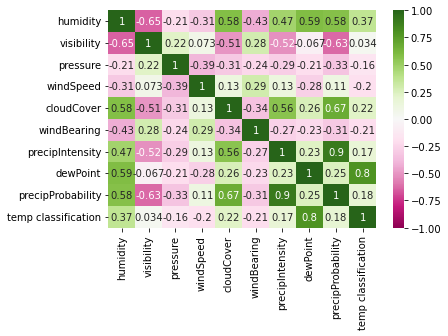

In [31]:
#Before creating logistic regression model, it is good to choose appropriate features
#check correlation
heatmap=sns.heatmap(task4_training_set.corr(), vmin=-1, vmax=1, annot=True, cmap='PiYG')

It shows that  "humidity" and "dew point" are highly correlated with "temp classfication", so we can use them as training and testing features

In [32]:
task4_training_features = task4_training_set[['humidity', 'dewPoint']]
task4_training_label = task4_training_set[['temp classification']]

task4_testing_features =task4_testing_set[['humidity','dewPoint']]
task4_testing_label = task4_testing_set[['temp classification']]

In [33]:
#scaling the training and testing features
scaler = StandardScaler()
task4_training_features = scaler.fit_transform(task4_training_features)
task4_testing_features = scaler.transform(task4_testing_features)

In [34]:
#build logistic regression model
logisticReg = LogisticRegression()
logisticReg.fit(task4_training_features, task4_training_label.values.ravel())
task4_predicted = logisticReg.predict(task4_testing_features)

In [35]:
#calculate the F1 score of the logistic regression model
f1_score(task4_testing_label,task4_predicted)

0.8125

In [36]:
#create csv dump of the classification
task4_predicted_df = task4_testing_label.copy()
task4_predicted_df['temp classification'] = task4_predicted
task4_predicted_df.to_csv('logistic_regression.csv')

In [37]:
#Task 5
# Energy usage data Analysis:
#We want to analyze how different devices are being used in different times of the day.
#- Is the washer being used only during the day?
#- During what time of the day is AC used most?
#There are a number of questions that can be asked.
#For simplicity, let’s divide a day in two parts:
#- Day: 6AM - 7PM
#- Night: 7PM - 6AM
#Analyze the usage of any two devices of your choice during the ‘day’ and ‘night’. Plot these trends. Explain your findings


#I added the column "Time" and "Day or Night" in order to classify Day and Night
#I set Day as 1 and and Night as 0
Task5_data = energy_data.copy()
Task5_data['Time'] = pd.to_datetime(Task5_data['Date & Time']).dt.time
Task5_data['Day or Night'] = Task5_data['Time'].apply(lambda x: 1 if x>=datetime.time(6,0) and x < datetime.time(19,0) else 0)

In [38]:
#First question = During what time of the day is AC used Most?

AC_day = Task5_data[Task5_data['Day or Night'] == 1]
AC_day = AC_day[['AC [kW]']]
AC_usage_during_day = AC_day['AC [kW]'].sum()

AC_night = Task5_data[Task5_data['Day or Night']==0]
AC_night = AC_night[['AC [kW]']]
AC_usage_during_night = AC_night['AC [kW]'].sum()

In [39]:
AC_usage_during_day

382.094051674

In [40]:
AC_usage_during_night

1177.164341666

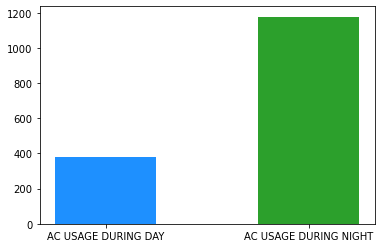

In [41]:
x = np.arange(2)
name = ['AC USAGE DURING DAY','AC USAGE DURING NIGHT']
values = [AC_usage_during_day, AC_usage_during_night]
plt.bar(x, values,width=0.5,color=['dodgerblue','C2'])
plt.xticks(x, name)
plt.show()

The bar graph shows that  AC usage during night is much higher than AC usage during night. I thought people would use AC more during day because temperature usually go to the highest between 12 and  2pm. To investigate why my assumption is wrong, I will create another graph that represents AC usage on different time zone of a day.

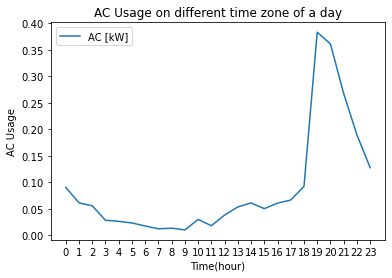

In [42]:
AC_timezone = Task5_data.copy()
AC_timezone['Hour'] = pd.to_datetime(AC_timezone['Date & Time']).dt.hour
AC_timezone = AC_timezone.groupby('Hour').mean()
AC_timezone = AC_timezone[['AC [kW]']]

AC_timezone.plot()
plt.title("AC Usage on different time zone of a day")
plt.xlabel("Time(hour)")
plt.ylabel("AC Usage")
plt.xticks(range(0,24))
plt.show()

The graph is showing that AC usage is rapidly increasing from 6 pm until 8 pm. I think the energy data is based on a regular household because people aren't usually at home durign day for work, school, and etc., and they are less likely to use AC that time. Also, people usually come back from work or school after 5 pm, and they start to turn on AC during evening time. This is why AC usage during day time is much higher than AC usage during night time.

In [43]:
#Second question = Is the washer being used only during the day?
washer_day = Task5_data[Task5_data['Day or Night'] == 1]
washer_day = washer_day[['Washer [kW]']]
washer_usage_during_day = washer_day['Washer [kW]'].sum()

washer_night = Task5_data[Task5_data['Day or Night']==0]
washer_night = washer_night[['Washer [kW]']]
washer_usage_during_night = washer_night['Washer [kW]'].sum()

In [44]:
washer_usage_during_day

43.634362779

In [45]:
washer_usage_during_night

10.101531092999998

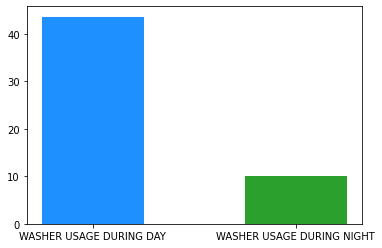

In [46]:
x = np.arange(2)
name = ['WASHER USAGE DURING DAY','WASHER USAGE DURING NIGHT']
values = [washer_usage_during_day, washer_usage_during_night]
plt.bar(x, values,width=0.5,color=['dodgerblue','C2'])
plt.xticks(x, name)
plt.show()

The bar graph shows that washer is mostly being used during a day. This is reasonable becasue some washers cause a huge noise and may interrupt people who are trying to sleep. Even though washer is mostly being used during a day, we still can see some usage during night, and now we are going to look at the graph that represents washer usage on different time zone of a day.

In [47]:
washer_timezone= Task5_data.copy()
washer_timezone['Hour'] = pd.to_datetime(washer_timezone['Date & Time']).dt.hour
washer_timezone = washer_timezone.groupby('Hour').mean()
washer_timezone = washer_timezone[['Washer [kW]']]

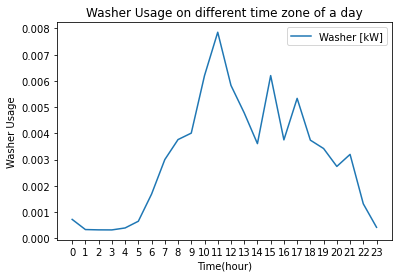

In [48]:
washer_timezone.plot()
plt.title("Washer Usage on different time zone of a day")
plt.xlabel("Time(hour)")
plt.ylabel("Washer Usage")
plt.xticks(range(0,24))
plt.show()

As shown above, we can see some washer usuage between 8 and 9 pm. I think it is because people who came back from work or school need to do laundry to prepare clean clothes for the next day.